In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# --- 1. Dataset & Dataloaders ---

# Define a custom dataset for contrastive learning.
# For each image, it returns two differently augmented views.
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

# Define the strong augmentations for the pretext task
pretext_transform = T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

# Define the simpler transform for the downstream classification task
downstream_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

# Paths to your dataset on Kaggle
DATA_DIR = '/kaggle/input/coffee-bean-dataset-resized-224-x-224'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Create the datasets
# For pretext training, we use the training set without labels
pretext_full_dataset = ImageFolder(root=TRAIN_DIR)
contrastive_dataset = ContrastiveDataset(pretext_full_dataset, pretext_transform)

# For downstream task (classification)
train_dataset = ImageFolder(root=TRAIN_DIR, transform=downstream_transform)
test_dataset = ImageFolder(root=TEST_DIR, transform=downstream_transform)
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")


# Create the dataloaders
pretext_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Number of classes: 4
Classes: ['Dark', 'Green', 'Light', 'Medium']


In [3]:
# --- 2. SimCLR Model & Loss Function ---

class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        # Use the model's feature extractor
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        # The output of ResNet50's feature extractor is 2048
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1) # Flatten
        projections = self.projection_head(features)
        return projections

def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, p=2, dim=1)

    similarity_matrix = torch.matmul(z, z.T) / temperature
    
    # Create a mask to identify positive pairs (i, i+B) and (i+B, i)
    positive_mask = torch.zeros_like(similarity_matrix, dtype=torch.bool)
    for i in range(batch_size):
        positive_mask[i, i + batch_size] = True
        positive_mask[i + batch_size, i] = True

    # Numerator: similarity of positive pairs
    numerator = torch.exp(similarity_matrix[positive_mask])

    # Denominator: sum of similarities of all other pairs (negative pairs)
    # We can achieve this by summing exponentiated similarities across each row
    # and subtracting the positive pair's contribution.
    # To avoid double counting, we create a mask to exclude the diagonal (self-similarity)
    self_mask = torch.eye(batch_size * 2, dtype=torch.bool, device=z.device)
    similarity_matrix.masked_fill_(self_mask, -float('inf'))
    
    denominator = torch.exp(similarity_matrix).sum(dim=1)
    
    # Calculate the loss for each sample and then take the mean
    loss = -torch.log(numerator / denominator).mean()

    return loss

In [4]:
# --- 3. Pretext Training ---

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize model
resnet = models.resnet50(weights=None) # From scratch
simclr_model = SimCLR(resnet).to(device)

# Optimizer
optimizer = optim.Adam(simclr_model.parameters(), lr=3e-4)

# Training loop
pretext_epochs = 50
pretext_losses = []

for epoch in range(pretext_epochs):
    simclr_model.train()
    total_loss = 0
    pbar = tqdm(pretext_loader, desc=f"Epoch {epoch+1}/{pretext_epochs}")
    for img1, img2 in pbar:
        img1, img2 = img1.to(device), img2.to(device)

        z1 = simclr_model(img1)
        z2 = simclr_model(img2)

        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = total_loss / len(pretext_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{pretext_epochs}] Pretext Loss: {avg_loss:.4f}")

# Save the pretrained model's encoder
# Note: We are saving the state_dict of the encoder part of SimCLR model
torch.save(simclr_model.encoder.state_dict(), 'simclr_encoder_coffee.pth')
print("Encoder model saved to simclr_encoder_coffee.pth")

Using device: cuda


Epoch 1/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1/50] Pretext Loss: 4.8208


Epoch 2/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2/50] Pretext Loss: 4.6406


Epoch 3/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3/50] Pretext Loss: 4.5160


Epoch 4/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4/50] Pretext Loss: 4.4741


Epoch 5/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5/50] Pretext Loss: 4.4652


Epoch 6/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6/50] Pretext Loss: 4.4485


Epoch 7/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7/50] Pretext Loss: 4.3671


Epoch 8/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8/50] Pretext Loss: 4.3434


Epoch 9/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9/50] Pretext Loss: 4.2971


Epoch 10/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [10/50] Pretext Loss: 4.2377


Epoch 11/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [11/50] Pretext Loss: 4.1775


Epoch 12/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [12/50] Pretext Loss: 4.2224


Epoch 13/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [13/50] Pretext Loss: 4.1880


Epoch 14/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [14/50] Pretext Loss: 4.1673


Epoch 15/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [15/50] Pretext Loss: 4.1807


Epoch 16/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [16/50] Pretext Loss: 4.1275


Epoch 17/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [17/50] Pretext Loss: 4.1082


Epoch 18/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [18/50] Pretext Loss: 4.0791


Epoch 19/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [19/50] Pretext Loss: 4.0822


Epoch 20/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [20/50] Pretext Loss: 4.1178


Epoch 21/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [21/50] Pretext Loss: 4.0684


Epoch 22/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [22/50] Pretext Loss: 4.0093


Epoch 23/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [23/50] Pretext Loss: 4.0322


Epoch 24/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [24/50] Pretext Loss: 3.9780


Epoch 25/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [25/50] Pretext Loss: 3.9331


Epoch 26/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [26/50] Pretext Loss: 3.8727


Epoch 27/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [27/50] Pretext Loss: 3.8909


Epoch 28/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [28/50] Pretext Loss: 3.8954


Epoch 29/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [29/50] Pretext Loss: 3.8843


Epoch 30/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [30/50] Pretext Loss: 3.8444


Epoch 31/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [31/50] Pretext Loss: 3.8330


Epoch 32/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [32/50] Pretext Loss: 3.7831


Epoch 33/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [33/50] Pretext Loss: 3.8011


Epoch 34/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [34/50] Pretext Loss: 3.7400


Epoch 35/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [35/50] Pretext Loss: 3.7422


Epoch 36/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [36/50] Pretext Loss: 3.7330


Epoch 37/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [37/50] Pretext Loss: 3.7033


Epoch 38/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [38/50] Pretext Loss: 3.6943


Epoch 39/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [39/50] Pretext Loss: 3.6663


Epoch 40/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [40/50] Pretext Loss: 3.6470


Epoch 41/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [41/50] Pretext Loss: 3.6644


Epoch 42/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [42/50] Pretext Loss: 3.6323


Epoch 43/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [43/50] Pretext Loss: 3.6029


Epoch 44/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [44/50] Pretext Loss: 3.6123


Epoch 45/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [45/50] Pretext Loss: 3.6398


Epoch 46/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [46/50] Pretext Loss: 3.6136


Epoch 47/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [47/50] Pretext Loss: 3.5868


Epoch 48/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [48/50] Pretext Loss: 3.5685


Epoch 49/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [49/50] Pretext Loss: 3.5709


Epoch 50/50:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [50/50] Pretext Loss: 3.5739
Encoder model saved to simclr_encoder_coffee.pth


In [6]:
# --- 4. Downstream Task: Linear Classification ---

# 1. Create the encoder architecture EXACTLY as it was during pretext training
#    This ensures the layer names match the saved file.
base_model = models.resnet50(weights=None)
encoder = nn.Sequential(*list(base_model.children())[:-1])

# 2. Load the saved weights into this matching architecture
encoder.load_state_dict(torch.load('simclr_encoder_coffee.pth', map_location=device))
encoder = encoder.to(device)

print("Pre-trained encoder loaded successfully!")

# 3. Freeze the encoder's weights
for param in encoder.parameters():
    param.requires_grad = False

# 4. Create the linear classifier
# The output of the nn.Sequential encoder is a (batch, 2048, 1, 1) tensor.
# We need to flatten it before the linear layer.
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, num_classes)
).to(device)


# Optimizer and loss for the classifier
# Note: We only pass the classifier's parameters to the optimizer
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop for the classifier
downstream_epochs = 50
downstream_losses = []
downstream_accuracies = []

for epoch in range(downstream_epochs):
    classifier.train()
    encoder.eval() # Encoder is in eval mode

    total_loss = 0
    correct, total = 0, 0

    pbar = tqdm(train_loader, desc=f"Classifier Epoch {epoch+1}/{downstream_epochs}")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            features = encoder(imgs)

        logits = classifier(features)
        loss = criterion(logits, labels)

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'Loss': loss.item(), 'Acc': (correct/total)*100})

    avg_loss = total_loss / len(train_loader)
    accuracy = (correct / total) * 100
    downstream_losses.append(avg_loss)
    downstream_accuracies.append(accuracy)

    print(f"Classifier Epoch [{epoch+1}/{downstream_epochs}] Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Pre-trained encoder loaded successfully!


Classifier Epoch 1/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [1/50] Loss: 0.7711, Accuracy: 63.08%


Classifier Epoch 2/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [2/50] Loss: 0.4117, Accuracy: 84.33%


Classifier Epoch 3/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [3/50] Loss: 0.3557, Accuracy: 85.58%


Classifier Epoch 4/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [4/50] Loss: 0.3408, Accuracy: 87.08%


Classifier Epoch 5/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [5/50] Loss: 0.3133, Accuracy: 87.67%


Classifier Epoch 6/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [6/50] Loss: 0.3146, Accuracy: 87.33%


Classifier Epoch 7/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [7/50] Loss: 0.3083, Accuracy: 86.92%


Classifier Epoch 8/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [8/50] Loss: 0.3028, Accuracy: 87.92%


Classifier Epoch 9/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [9/50] Loss: 0.2862, Accuracy: 88.25%


Classifier Epoch 10/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [10/50] Loss: 0.2840, Accuracy: 88.17%


Classifier Epoch 11/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [11/50] Loss: 0.2754, Accuracy: 88.75%


Classifier Epoch 12/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [12/50] Loss: 0.3136, Accuracy: 87.17%


Classifier Epoch 13/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [13/50] Loss: 0.2997, Accuracy: 88.08%


Classifier Epoch 14/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [14/50] Loss: 0.2727, Accuracy: 89.25%


Classifier Epoch 15/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [15/50] Loss: 0.2772, Accuracy: 89.58%


Classifier Epoch 16/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [16/50] Loss: 0.2800, Accuracy: 88.67%


Classifier Epoch 17/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [17/50] Loss: 0.2703, Accuracy: 89.50%


Classifier Epoch 18/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [18/50] Loss: 0.2697, Accuracy: 88.83%


Classifier Epoch 19/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [19/50] Loss: 0.2690, Accuracy: 89.42%


Classifier Epoch 20/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [20/50] Loss: 0.2730, Accuracy: 89.50%


Classifier Epoch 21/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [21/50] Loss: 0.2728, Accuracy: 89.42%


Classifier Epoch 22/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [22/50] Loss: 0.2664, Accuracy: 89.67%


Classifier Epoch 23/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [23/50] Loss: 0.2639, Accuracy: 89.42%


Classifier Epoch 24/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [24/50] Loss: 0.2589, Accuracy: 89.42%


Classifier Epoch 25/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [25/50] Loss: 0.2608, Accuracy: 89.17%


Classifier Epoch 26/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [26/50] Loss: 0.2722, Accuracy: 89.17%


Classifier Epoch 27/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [27/50] Loss: 0.2560, Accuracy: 89.58%


Classifier Epoch 28/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [28/50] Loss: 0.2532, Accuracy: 90.33%


Classifier Epoch 29/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [29/50] Loss: 0.2440, Accuracy: 90.08%


Classifier Epoch 30/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [30/50] Loss: 0.2560, Accuracy: 90.00%


Classifier Epoch 31/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [31/50] Loss: 0.2483, Accuracy: 90.17%


Classifier Epoch 32/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [32/50] Loss: 0.2758, Accuracy: 89.42%


Classifier Epoch 33/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [33/50] Loss: 0.2649, Accuracy: 90.33%


Classifier Epoch 34/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [34/50] Loss: 0.2659, Accuracy: 89.33%


Classifier Epoch 35/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [35/50] Loss: 0.2656, Accuracy: 90.25%


Classifier Epoch 36/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [36/50] Loss: 0.2468, Accuracy: 90.25%


Classifier Epoch 37/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [37/50] Loss: 0.2546, Accuracy: 90.33%


Classifier Epoch 38/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [38/50] Loss: 0.2465, Accuracy: 90.83%


Classifier Epoch 39/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [39/50] Loss: 0.2525, Accuracy: 90.17%


Classifier Epoch 40/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [40/50] Loss: 0.2348, Accuracy: 90.50%


Classifier Epoch 41/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [41/50] Loss: 0.2587, Accuracy: 89.33%


Classifier Epoch 42/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [42/50] Loss: 0.2575, Accuracy: 89.75%


Classifier Epoch 43/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [43/50] Loss: 0.2538, Accuracy: 90.33%


Classifier Epoch 44/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [44/50] Loss: 0.2509, Accuracy: 90.58%


Classifier Epoch 45/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [45/50] Loss: 0.2549, Accuracy: 90.25%


Classifier Epoch 46/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [46/50] Loss: 0.2527, Accuracy: 90.00%


Classifier Epoch 47/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [47/50] Loss: 0.2531, Accuracy: 89.75%


Classifier Epoch 48/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [48/50] Loss: 0.2640, Accuracy: 90.17%


Classifier Epoch 49/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [49/50] Loss: 0.2637, Accuracy: 88.67%


Classifier Epoch 50/50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifier Epoch [50/50] Loss: 0.2879, Accuracy: 88.58%


In [7]:
# --- 5. Evaluation ---

from sklearn.metrics import classification_report, accuracy_score

all_preds, all_labels = [], []

# Set models to evaluation mode
classifier.eval()
encoder.eval()

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)

        features = encoder(imgs)
        logits = classifier(features)

        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\n--- Test Report ---")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
print(f"Final Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

Testing:   0%|          | 0/4 [00:00<?, ?it/s]


--- Test Report ---
              precision    recall  f1-score   support

        Dark       0.82      0.98      0.89       100
       Green       0.91      0.96      0.93       100
       Light       0.94      0.90      0.92       100
      Medium       0.97      0.77      0.86       100

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400

Final Test Accuracy: 90.25%


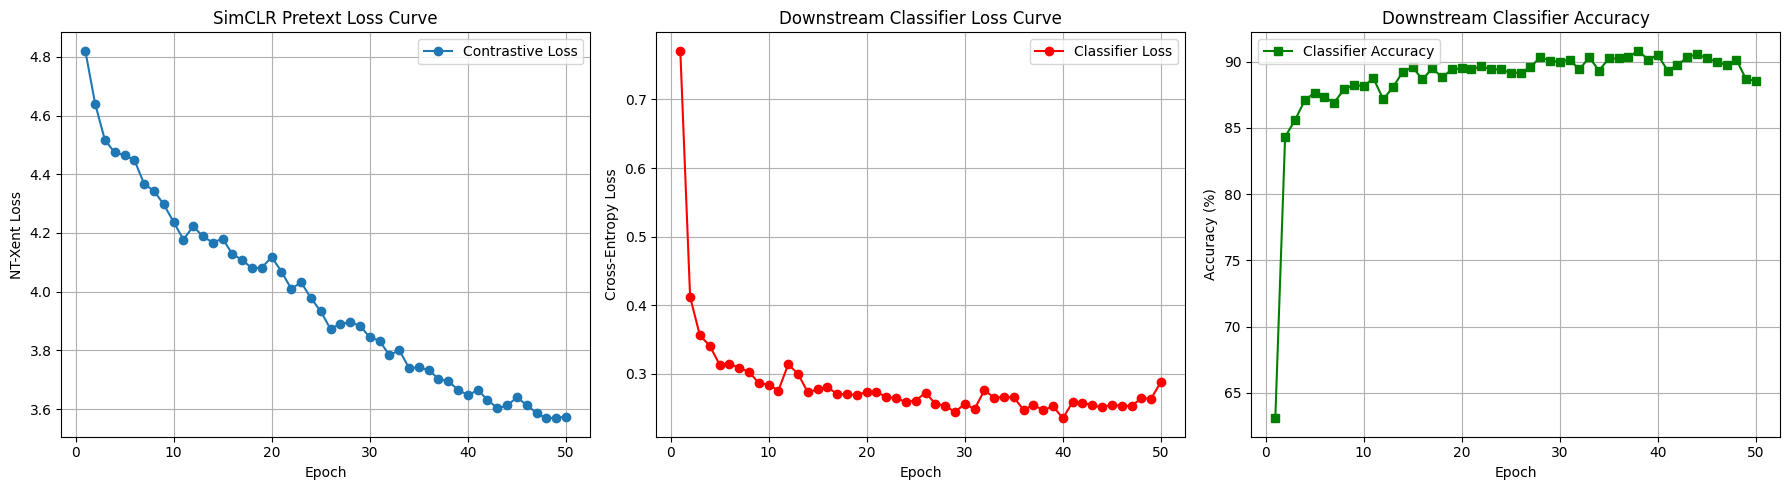

In [8]:
# --- 6. Plotting ---

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(pretext_losses) + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Pretext Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(downstream_losses) + 1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, len(downstream_accuracies) + 1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()